<a href="https://colab.research.google.com/github/lorenzobalzani/bayesian-network-credit-cards/blob/master/bayesian_network_credit_cards_default.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Title: Bayesian Networks for reasoning over credit cards' default causes
## Course: Fundamentals of AI and KR module 3
### Authors: [**Lorenzo Balzani**](mailto:lorenzo.balzani@studio.unibo.it) and [**Thomas Guizzetti**](mailto:thomas.guizzetti@studio.unibo.it)

# Abstract
TODO

# Setup

## Requirements

In [ ]:
!pip install -q pandas numpy pgmpy

## Imports

In [102]:
import os, logging
import pandas as pd
import numpy as np
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete.CPD import TabularCPD
from pgmpy.inference import VariableElimination
from pgmpy.estimators import ParameterEstimator, MaximumLikelihoodEstimator, BayesianEstimator, TreeSearch, HillClimbSearch, BDeuScore
from sklearn.model_selection import train_test_split

# Viz
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns

## Declarations

In [103]:
logger = logging.getLogger()
dataset_url = 'https://raw.githubusercontent.com/lorenzobalzani/bayesian-network-credit-cards/master/dataset.csv'
test_ratio = 0.2
random_seed = 42

# Dataset

In [ ]:
def read_dataset(url: str) -> pd.DataFrame:
  dataset = pd.read_csv(url, delimiter=';').set_index('ID') \
            .rename(columns={'default payment next month': 'default'})
  return dataset.drop(columns=[column for column in dataset.columns if 'AMT' in column]) \
         .rename(columns={column: column.lower() for column in dataset.columns})

dataset = read_dataset(dataset_url)

## Distribution of `limit_bal` 
First, we print out the histogram related to the distribution of `limit_bal`, which is the only continuous variable used.

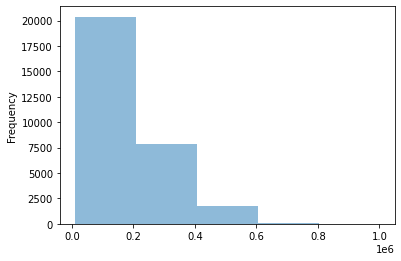

In [ ]:
ax = dataset['limit_bal'].plot.hist(bins=5, alpha=0.5)

Next, we describe the distribution. To discretize it, we would like to create four beams (i.e., corresponding to the four percentiles).

In [ ]:
dataset['limit_bal'].describe()

count      30000.000000
mean      167484.322667
std       129747.661567
min        10000.000000
25%        50000.000000
50%       140000.000000
75%       240000.000000
max      1000000.000000
Name: limit_bal, dtype: float64

## Manipulation
The *artificial column* `misspayments_prev_6_months` can hold either positive, negative numbers or 0. In particular, this means: 
1. $ n = -2 $ corresponds to there was no credit to pay;
2. $ n = -1 $ corresponds to payed successfully;
3. $ n = 0 $ corresponds to a payment that was made on time but not totally to clear the balance (i.e., the minimum payment was met);
4. $ n > 0 $ corresponds to the number of delayed months.

All computations - but `misspayments_prev_6_months` - are performed in a vectorized fashion using NumPy. The less efficient alternative would have used the `apply` method over Pandas DataFrame, which internally leverages a for loop.

In [ ]:
%%time

def manipulate_dataset(df: pd.DataFrame) -> pd.DataFrame:
  compute_misspayments = lambda payments_status: sum([payment_status > 0 for payment_status in payments_status])
  df['sex'] = np.where(df['sex'] == 1, 'male', 'female')
  df['marriage'] = np.where(df['marriage'] == 1, 'married', 'not_married')
  df['age'] = np.select([
              (df['age'] < 35), 
              (df['age'] >= 35) & (df['age'] < 60)],
              ['young', 'mid_aged'], default = 'senior')
  df['limit_bal'] = np.select([
                    (df['limit_bal'] < 50_000), 
                    (df['limit_bal'] >= 50_000) & (df['limit_bal'] < 140_000),
                    (df['limit_bal'] >= 140_000) & (df['limit_bal'] < 240_000)],
                    ['low', 'medium', 'medium_high'], default = 'high')
  df['education'] = np.select([
                    (df['education'] == 1), 
                    (df['education'] == 2), 
                    (df['education'] == 3)], 
                    ['graduate', 'university', 'high_school'], default = 'others') 
  df['misspayments_prev_6_months'] = df.apply(lambda row: \
                                              compute_misspayments([row[column] for column in df.columns if 'pay_' in column]), 
                                              axis=1) #axis = 1 means row by row
  return df.drop(columns=[column for column in df.columns if 'pay_' in column])

dataset = manipulate_dataset(read_dataset(dataset_url))

CPU times: user 1.94 s, sys: 24.6 ms, total: 1.96 s
Wall time: 4.84 s


## Final dataset

In [ ]:
dataset.head()

,limit_bal,sex,education,marriage,age,default,misspayments_prev_6_months
ID,,,,,,,
1,low,female,university,married,young,1,2
2,medium,female,university,not_married,young,1,2
3,medium,female,university,not_married,young,0,0
4,medium,female,university,married,mid_aged,0,0
5,medium,male,university,married,mid_aged,0,0


TBC: Description of final dataset and its values

# Train/test split

In [122]:
X_train, X_test, y_train, y_test = train_test_split(dataset.drop('default', axis=1), dataset['default'], \
                                                    test_size=test_ratio, random_state=random_seed, \
                                                    stratify=dataset['default'])
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)
print("Training set size: " + str(train.shape[0]))
print("Test set size: " + str(test.shape[0]))
print("Total size: " + str(train.shape[0] + test.shape[0]))

Training set size: 24000
Test set size: 6000
Total size: 30000


# States
List - for each variable - the associated states, i.e. every possibile unique value in the domain $D$ of a random variable.

In [ ]:
state_names = {col_name: column.unique() for col_name, column in dataset.iteritems()}

# Hard-coded networks

In [ ]:
#Bayesian Network - Easy
model_easy = BayesianModel([('education', 'limit_bal'), ('age', 'limit_bal'), \
                       ('marriage', 'limit_bal'), ('sex', 'limit_bal'), \
                       ('limit_bal', 'default'), ('misspayments_prev_6_months', 'default')])

#Bayesian Network - Medium
model_medium = BayesianModel([("age", "marriage"), ("age", "education"), \
                       ("age", "education"),("age", "default"), \
                       ("education", "limit_credit"), ("marriage", "limit_credit"), \
                       ("limit_credit", "default"), ("sex", "limit_credit"), \
                       ("misspayments", "default")])

#Bayesian Network - Hard
model_hard = BayesianModel([("age", "marriage"), ("age", "education"), \
                       ("age", "education"),("age", "default"), \
                       ("education", "limit_bal"), ("marriage", "limit_bal"), \
                       ("limit_bal", "default"), ("sex", "limit_bal"), \
                       ("misspayments_prev_6_months", "default"), ("education", "default"), \
                       ("marriage", "default")])

## Parameter learning
Parameter are estimated given an already-defined $DAG = \{V, E\}$. The estimation is related to every random variable's *CPT*.

In [123]:
model_hard.fit(train, estimator=BayesianEstimator, prior_type="BDeu")
nb_cpds = model_hard.get_cpds()
TabularCPD._truncate_strtable = lambda self, x: x
for cpd in nb_cpds:
  print(cpd)
if not model_hard.check_model():
    print('The NB model has errors.')
else:
    print('The NB model has no errors.')

+---------------+-----------+
| age(mid_aged) | 0.462473  |
+---------------+-----------+
| age(senior)   | 0.0110255 |
+---------------+-----------+
| age(young)    | 0.526501  |
+---------------+-----------+
+-----------------------+--------------------+---------------------+---------------------+
| age                   | age(mid_aged)      | age(senior)         | age(young)          |
+-----------------------+--------------------+---------------------+---------------------+
| marriage(married)     | 0.6846569584146525 | 0.8268261964735516  | 0.24328779407110454 |
+-----------------------+--------------------+---------------------+---------------------+
| marriage(not_married) | 0.3153430415853476 | 0.17317380352644837 | 0.7567122059288954  |
+-----------------------+--------------------+---------------------+---------------------+
+------------------------+----------------------+----------------------+----------------------+
| age                    | age(mid_aged)        | age(sen

# Queries

## Query data

* P(Default | age) 
* P(Default | age, marriage)
* P(Default | age, marriage, education)
* P(Education = graduate | default)
* P(Default | Education = graduate, Misspayment = 5)
* P(Default | Education = High school, Misspayment = 5)

*TBC: Explain why we're using variable elimination (Optional, construct algorigthm instead of using class)*

In [ ]:
data_infer = VariableElimination(model_hard)

In [ ]:
# Computing the probability of default given age = young.
query_1 = data_infer.query(variables=["default"], evidence={"age": "young"})
print(query_1)

query_1 = data_infer.query(variables=["default"], evidence={"age": "mid_aged"})
print(query_1)

query_1 = data_infer.query(variables=["default"], evidence={"age": "senior"})
print(query_1)

# Computing the probability of default given age and marriage
query_2 = data_infer.query(variables=["default"], evidence={"age": "mid_aged", "marriage": "not_married"})
print(query_2)

# Computing the probability of default given age, marriage and education
query_3 = data_infer.query(variables=["default"], evidence={"age": "mid_aged", "marriage": "married", "education": "graduate"})
print(query_3)

# Computing the probability of education given default
query_4 = data_infer.query(variables=["education"], evidence={"default": 1})
print(query_4)

# Computing the probability of default given education and misspayment
query_5 = data_infer.query(variables=["default"], evidence={"education": "graduate", "misspayments_prev_6_months": 5})
print(query_5)

# Computing the probability of default given education and misspayment
query_6 = data_infer.query(variables=["default"], evidence={"education": "high_school", "misspayments_prev_6_months": 5})
print(query_5)

query_6 = data_infer.query(variables=["default"], evidence={"limit_bal": "medium_high", "misspayments_prev_6_months": 6})
print(query_6)

+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.7917 |
+------------+----------------+
| default(1) |         0.2083 |
+------------+----------------+
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.7647 |
+------------+----------------+
| default(1) |         0.2353 |
+------------+----------------+
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.7281 |
+------------+----------------+
| default(1) |         0.2719 |
+------------+----------------+
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.7624 |
+------------+----------------+
| default(1) |         0.2376 |
+------------+----------------+
+------------+----------------+
| default    |   phi(default) |
+============+================+
| defaul

# Structural Learning
Since query results are poor when comparing three different models, there is likely no difference betwee the three represetations and thus, we should seek a different model structure.

## 

Building tree:   0%|          | 0/21.0 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/pgmpy/models/BayesianModel.py:10: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  FutureWarning,


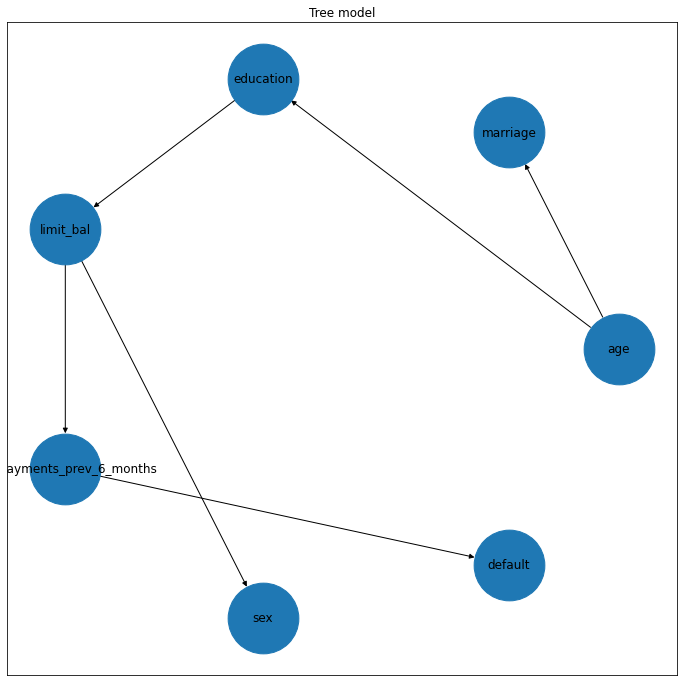

In [ ]:
ts = TreeSearch(data=train, root_node='age')
tree_model = ts.estimate(show_progress=True)

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
nx.draw_networkx(tree_model, pos=nx.drawing.layout.circular_layout(tree_model), ax=ax, node_size=5000)
fig.savefig('tree')
ax.set_title('Tree model')
tree_model = BayesianModel(tree_model.edges())

  0%|          | 0/1000000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/pgmpy/models/BayesianModel.py:10: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  FutureWarning,


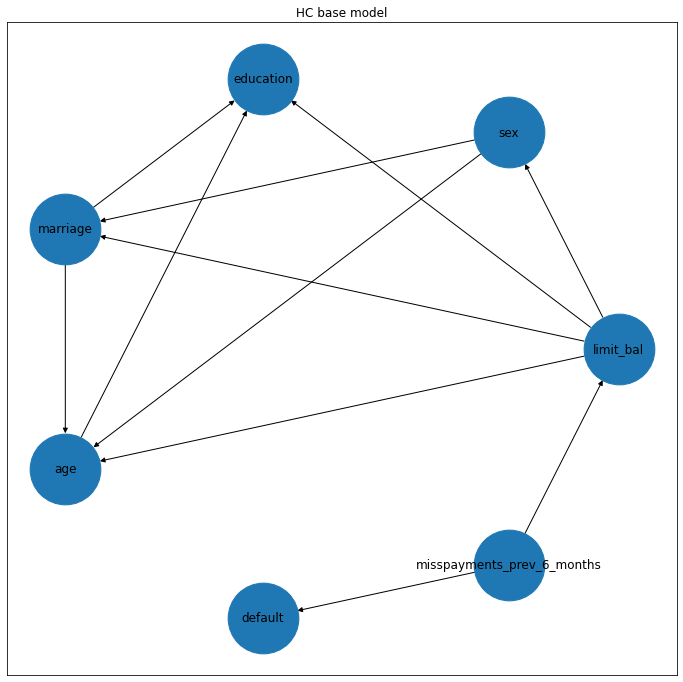

In [97]:
scorer = BDeuScore(data=train)
hc = HillClimbSearch(data=train)
hc_base_model = hc.estimate(scoring_method=scorer, show_progress=True)

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
nx.draw_networkx(hc_base_model, pos=nx.drawing.layout.circular_layout(hc_base_model), ax=ax, node_size=5000)
fig.savefig('hc_base')
ax.set_title('HC base model')
hc_base_model = BayesianModel(hc_base_model.edges())

# Hill climb constrained model

/usr/local/lib/python3.7/dist-packages/pgmpy/models/BayesianModel.py:10: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  FutureWarning,


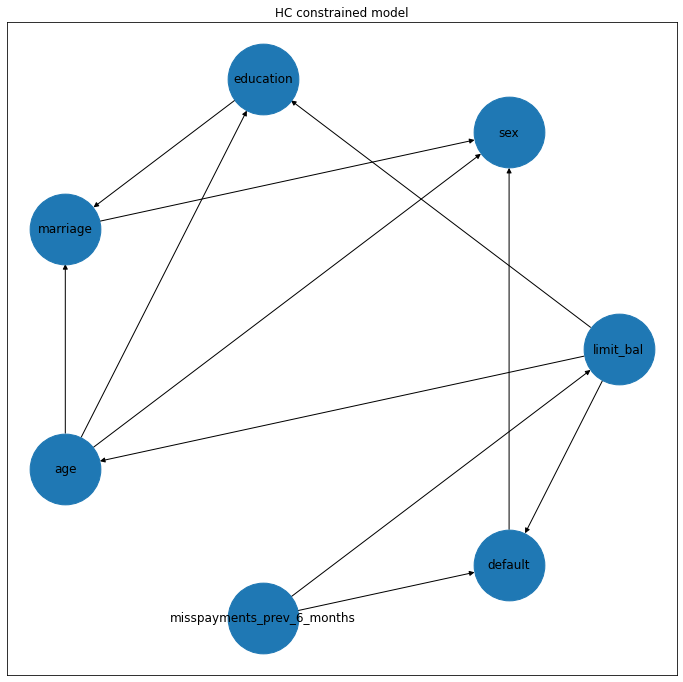

In [124]:
fixed_edges = [('misspayments_prev_6_months', 'default'), ('limit_bal', 'default')] # TODO add here
black_list = [('limit_bal', 'sex'), ('limit_bal', 'marriage')] # TODO add here

scorer = BDeuScore(data=train)
hc = HillClimbSearch(data=train)
hc_constr_model = hc.estimate(scoring_method=scorer, fixed_edges=fixed_edges, black_list=black_list, show_progress=False)

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
nx.draw_networkx(hc_constr_model, pos=nx.drawing.layout.circular_layout(hc_constr_model), ax=ax, node_size=5000)
fig.savefig('hc_constrained')
ax.set_title('HC constrained model')
hc_constr_model = BayesianModel(hc_constr_model.edges())